In [1]:
!pip install openai langchain-community langchain-openai langgraph crewai-tools langchain-chroma langchain langchain-text-splitters langchain_core langchain_huggingface pypdf

INFO: pip is looking at multiple versions of crewai to determine which version is compatible with other requirements. This could take a while.
  Using cached crewai_tools-1.8.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 765.0/765.0 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 642.9/642.9 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.6/948.6 kB 48.8 MB/s eta 0:00:00
  Attempting uninstall: json-repair
    Found existing installation: json_repair 0.25.3
    Uninstalling json_repair-0.25.3:
      Successfully uninstalled json_repair-0.25.3
  Attempting uninstall: openai
    Found existing installation: openai 2.15.0
    Uninstalling openai-2.15.0:
      Successfully uninstalled openai-2.15.0
  Attempting uninstall: crewai
    Found existing installation: crewai 1.8.0
    Uninstalling crewai-1.8.0:
      Successfully uninstalled crewai-1.8.0
  Attempting uninstall: crewai-tools
    Found existing installa

In [3]:
import os
import re
from typing import Literal, TypedDict
from openai import OpenAI
from langchain_openai import ChatOpenAI
from langchain_core.prompts import PromptTemplate
from crewai_tools import SerperDevTool
from langchain.tools import tool
from langgraph.prebuilt import create_react_agent
from langgraph.graph import START, StateGraph, END
from IPython.display import Image, display

In [4]:
BASE_URL = "https://openrouter.ai/api/v1"
API_KEY=...................................
MODEL_1 = "mistralai/devstral-2512:free"
MODEL_2 = "xiaomi/mimo-v2-flash:free"

In [5]:
llm = ChatOpenAI(
    model=MODEL_1,
    openai_api_key=OPENROUTER_API_KEY,
    openai_api_base=BASE_URL,
    temperature=0.7,
    max_tokens=1024,
    default_headers={
        "HTTP-Referer": "https://company-chatbot.local",
        "X-Title": "Multi-Agent System",
    }
)

In [6]:
@tool
def serper_search(user_query: str) -> str:
    """
    Perform a real-time web search using the Serper API.

    This tool takes a plain-text user query, sends it to Serper (a web search API),
    and returns a string with the top relevant results. Useful for finding current
    information, news, events, and real-time data from the internet.

    Args:
        user_query (str): A natural language search prompt.

    Returns:
        str: A formatted string of search results from Serper.
    """
    try:
        return SerperDevTool().run(query=user_query)
    except Exception as e:
        return f"Search failed: {str(e)}"


In [7]:
# --- Define State ---
class AgentState(TypedDict):
    """State shared across all nodes in the graph."""
    user_query: str
    answer: str

# --- Agent Nodes ---
def router_agent(state: AgentState) -> dict:
    """
    Captures user input and initializes the workflow.

    This function prompts the user to enter a query via the console,
    then stores that input in the shared state for routing to appropriate agents.

    Args:
        state (AgentState): The current state dictionary.

    Returns:
        dict: Updated state containing the user's query.
    """
    print("\n--- Router Agent: Receiving Input ---")
    user_input = input("Enter your query: ").strip()

    if not user_input:
        user_input = "What is 25 * 4 + 10?"  # Default query for testing
        print(f"Using default query: {user_input}")

    return {"user_query": user_input}

def search_agent(state: AgentState) -> dict:
    """
    Executes a ReAct-style agent that searches the web for information.

    This agent uses the Serper search tool to gather up-to-date information
    from the internet and provides a comprehensive answer to the user's query.

    Args:
        state (AgentState): Contains the user's query.

    Returns:
        dict: Updated state with the generated answer.
    """
    print("\n--- Search Agent: Processing Query ---")

    try:
        agent = create_react_agent(llm, [serper_search])
        result = agent.invoke({"messages": [("user", state["user_query"])]})
        answer = result["messages"][-1].content
    except Exception as e:
        answer = f"Search agent error: {str(e)}"

    return {"answer": answer}

In [8]:
def math_agent(state: AgentState) -> dict:
    """
    A math-solving agent that uses the LLM to process and solve mathematical problems.

    This agent is specialized in handling calculations, equations, and quantitative
    reasoning tasks. It returns precise numerical answers.

    Args:
        state (AgentState): Contains the user's query.

    Returns:
        dict: Updated state with the computed answer from the LLM.
    """
    print("\n--- Math Agent: Solving Problem ---")

    prompt = f"""You are a math expert. Solve this problem step by step and provide the final answer.

Problem: {state['user_query']}

Show your work and clearly state the final answer."""

    try:
        response = llm.invoke(prompt)
        answer = response.content.strip()
    except Exception as e:
        answer = f"Math agent error: {str(e)}"

    return {"answer": answer}

# --- Routing Logic ---
def routing_logic(state: AgentState) -> Literal["math_agent", "search_agent"]:
    """
    Uses the LLM to intelligently route queries to the appropriate agent.

    Analyzes the user query and determines whether it requires mathematical
    computation (math_agent) or web search capabilities (search_agent).

    Args:
        state (AgentState): The current state containing the user query.

    Returns:
        str: The name of the next node to route to.
    """
    print("\n--- Routing Logic: Analyzing Query ---")

    prompt = f"""You are a routing system. Analyze this query and decide which agent should handle it.

User Query: "{state['user_query']}"

Available Agents:
1. math_agent - For calculations, equations, mathematical problems, arithmetic, algebra, geometry, etc.
2. search_agent - For current events, facts, news, information lookup, research questions, etc.

Rules:
- Choose math_agent ONLY if the query involves numerical computation or solving equations
- Choose search_agent for anything requiring current/factual information from the web
- Respond with ONLY the agent name: either "math_agent" or "search_agent"

Decision:"""

    try:
        response = llm.invoke(prompt)
        decision = response.content.strip().lower()

        if "math_agent" in decision:
            print("→ Routing to: Math Agent")
            return "math_agent"
        else:
            print("→ Routing to: Search Agent")
            return "search_agent"
    except Exception as e:
        print(f"Routing error: {e}. Defaulting to search_agent")
        return "search_agent"

In [9]:
# --- Build the Graph ---
def create_workflow():
    """
    Constructs the LangGraph workflow with routing logic.

    Returns:
        Compiled graph application ready for execution.
    """
    workflow = StateGraph(AgentState)

    # Add nodes
    workflow.add_node("router_agent", router_agent)
    workflow.add_node("search_agent", search_agent)
    workflow.add_node("math_agent", math_agent)

    # Add edges
    workflow.add_edge(START, "router_agent")
    workflow.add_conditional_edges("router_agent", routing_logic)
    workflow.add_edge("search_agent", END)
    workflow.add_edge("math_agent", END)

    return workflow.compile()


In [10]:
def main():
    """Main function to run the multi-agent system."""
    print("="*60)
    print("Multi-Agent System with OpenRouter & LangGraph")
    print("="*60)

    # Create and compile the workflow
    app = create_workflow()

    # Optional: Visualize the graph
    try:
        display(Image(app.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Could not display graph visualization: {e}")

    # Run the workflow
    result = app.invoke({})

    # Display results
    print("\n" + "="*60)
    print("FINAL ANSWER:")
    print("="*60)
    print(result.get("answer", "No answer generated"))
    print("="*60)

    return result


Multi-Agent System with OpenRouter & LangGraph


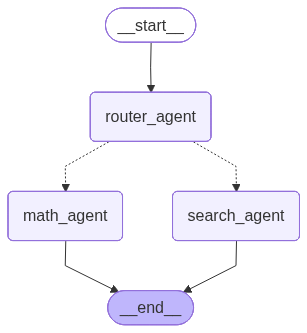


--- Router Agent: Receiving Input ---
Enter your query: tell me about imran khan?

--- Routing Logic: Analyzing Query ---
→ Routing to: Search Agent

--- Search Agent: Processing Query ---


/tmp/ipython-input-3012476627.py:46: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  agent = create_react_agent(llm, [serper_search])


Using Tool: Search the internet with Serper

FINAL ANSWER:
It seems I encountered an issue while trying to fetch the latest information about Imran Khan. However, here's a brief overview based on general knowledge:

**Imran Khan** is a prominent Pakistani politician, former cricketer, and philanthropist. He was born on October 5, 1952, in Lahore, Pakistan. Khan is widely regarded as one of the greatest cricketers in Pakistan's history, having led the national team to its first-ever Cricket World Cup victory in 1992. After retiring from cricket, he entered politics and founded the Pakistan Tehreek-e-Insaf (PTI) party in 1996.

Khan served as the Prime Minister of Pakistan from August 2018 until April 2022, when he was removed from office through a no-confidence motion. His political career has been marked by a focus on anti-corruption, social justice, and economic reform. He is also known for his philanthropic work, including the establishment of the Shaukat Khanum Memorial Cancer Hospi

In [12]:
if __name__ == "__main__":
    main()